<a href="https://colab.research.google.com/github/AlexanderMATI/FilmML/blob/main/Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1163]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

2.7.0


## 1. Загрузка данных

In [1164]:
import pandas as pd
import numpy as np

In [1165]:
#загружаем данные для обучения
#train_df = pd.read_csv('/content/data_id.csv',sep=';',encoding="cp1251")
train_df = pd.read_csv("/content/train.tsv")
#train_df = pd.read_csv('/content/train.csv',encoding="utf-8")
train_df

,id,Title,Release_Year,Genre,Synopsis
0,0,Белорусский вокзал,1970,драма,Культовая советская драма режиссера Андрея Сми...
1,1,Судьба человека,1959,военный,"Кинодебют Сергея Бондарчука – режиссера, экран..."
2,2,Счастье в конверте,2020,драма,Три сотрудницы почтового отделения собираются ...
3,3,Брат 2,2000,криминал,Легендарную фразу Данилы Багрова «Скоро всей в...
4,4,Легенда №17,2012,Спорт,Данила Козловский и Олег Меньшиков в спортивно...
...,...,...,...,...,...
578,578,Любовь по-японски,2018,драма,драма от режиссера скетч-шоу «Одна за всех» и ...
579,579,Ты будешь моей,2013,драма,Телевизионный фильм совместного производства Р...
580,580,Месяц май,1965,драма,"Алла Чернова («Тайна «Черных дроздов», «Ночная..."
581,581,Берега любви,2013,драма,Когда строгая Вера застукала на сеновале супру...


,Genre,Genre_cnt
0,драма,261
1,комедия,128
2,детектив,39
3,военный,37
4,документальный,35
5,боевик,18
6,приключения,14
7,Для детей,12
8,криминал,11
9,фантастика,5


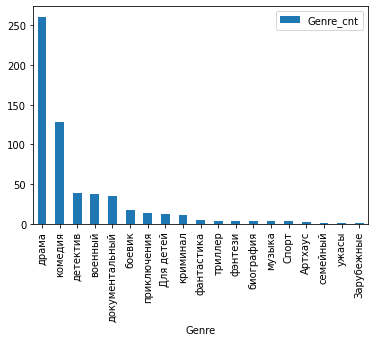

In [1166]:
# Посмотрим распределение по жанрам

genre_count_df = train_df[['id','Genre']].groupby('Genre').agg('count').sort_values('id', ascending = False)

genre_count_df.reset_index(inplace = True)
genre_count_df.rename(columns ={'id':'Genre_cnt'}, inplace = True)

genre_count_df.plot.bar(y = 'Genre_cnt', x = 'Genre')

genre_count_df

In [1167]:
train_df = train_df.merge(genre_count_df, how = 'left', left_on='Genre', right_on='Genre')

train_df

,id,Title,Release_Year,Genre,Synopsis,Genre_cnt
0,0,Белорусский вокзал,1970,драма,Культовая советская драма режиссера Андрея Сми...,261
1,1,Судьба человека,1959,военный,"Кинодебют Сергея Бондарчука – режиссера, экран...",37
2,2,Счастье в конверте,2020,драма,Три сотрудницы почтового отделения собираются ...,261
3,3,Брат 2,2000,криминал,Легендарную фразу Данилы Багрова «Скоро всей в...,11
4,4,Легенда №17,2012,Спорт,Данила Козловский и Олег Меньшиков в спортивно...,3
...,...,...,...,...,...,...
578,578,Любовь по-японски,2018,драма,драма от режиссера скетч-шоу «Одна за всех» и ...,261
579,579,Ты будешь моей,2013,драма,Телевизионный фильм совместного производства Р...,261
580,580,Месяц май,1965,драма,"Алла Чернова («Тайна «Черных дроздов», «Ночная...",261
581,581,Берега любви,2013,драма,Когда строгая Вера застукала на сеновале супру...,261


In [1168]:
# Уберем редко встречающиеся варианты

GENRE_CNT_MIN = 100

train_df = train_df [train_df['Genre_cnt'] > GENRE_CNT_MIN]

train_df

,id,Title,Release_Year,Genre,Synopsis,Genre_cnt
0,0,Белорусский вокзал,1970,драма,Культовая советская драма режиссера Андрея Сми...,261
2,2,Счастье в конверте,2020,драма,Три сотрудницы почтового отделения собираются ...,261
5,5,Тот самый Мюнхгаузен,1979,комедия,Одна из самых ярких и запоминающихся ролей выд...,128
7,7,Республика ШКИД,1966,комедия,"Знаменитая картина ""Республика ШКИД"" рассказыв...",128
8,8,Человек с бульвара Капуцинов,1987,драма,Комедийный вестерн от создателей «Будьте моим ...,261
...,...,...,...,...,...,...
577,577,Любви целительная сила,2012,драма,"Аня побеждает в конкурсе красоты, но её радост...",261
578,578,Любовь по-японски,2018,драма,драма от режиссера скетч-шоу «Одна за всех» и ...,261
579,579,Ты будешь моей,2013,драма,Телевизионный фильм совместного производства Р...,261
580,580,Месяц май,1965,драма,"Алла Чернова («Тайна «Черных дроздов», «Ночная...",261


In [1169]:
#Загружаем тестовые данные

test_df = pd.read_csv('/content/test.tsv')
#test_df = pd.read_csv('/content/datafull.csv',sep=';',encoding="cp1251")

test_df

,id,Title,Release_Year,Genre,Synopsis
0,583,Курортный туман,2012,детектив,Алена Бабенко в детективном триллере от режисс...
1,584,Игрушка,2019,детектив,"Психотерапевт Алиса Савельева узнает, что ее п..."
2,585,Щедрое лето,1950,драма,"Музыкальный фильм советского режиссера, актера..."
3,586,Девушки бывают разные,2019,комедия,Троица друзей-туристов во время бурной вечерин...
4,587,Доминика,2018,фэнтези,"Костя молод, успешен и привык прятать все свои..."
...,...,...,...,...,...
578,1161,Лавина,2008,драма,Как часто любовное приключение приводит нас к ...
579,1162,Чупакабра,2020,драма,Девятилетний Андрей живёт без родительской люб...
580,1163,Белые росы. Возвращение,2014,комедия,Фильм-продолжение советской трагикомедия «Белы...
581,1164,Знахарка,2012,драма,Отечественный мини-сериал «Знахарка» поведает ...


In [1170]:
test_df = test_df.merge(genre_count_df, how = 'left', left_on='Genre', right_on='Genre')

test_df

,id,Title,Release_Year,Genre,Synopsis,Genre_cnt
0,583,Курортный туман,2012,детектив,Алена Бабенко в детективном триллере от режисс...,39.0
1,584,Игрушка,2019,детектив,"Психотерапевт Алиса Савельева узнает, что ее п...",39.0
2,585,Щедрое лето,1950,драма,"Музыкальный фильм советского режиссера, актера...",261.0
3,586,Девушки бывают разные,2019,комедия,Троица друзей-туристов во время бурной вечерин...,128.0
4,587,Доминика,2018,фэнтези,"Костя молод, успешен и привык прятать все свои...",4.0
...,...,...,...,...,...,...
578,1161,Лавина,2008,драма,Как часто любовное приключение приводит нас к ...,261.0
579,1162,Чупакабра,2020,драма,Девятилетний Андрей живёт без родительской люб...,261.0
580,1163,Белые росы. Возвращение,2014,комедия,Фильм-продолжение советской трагикомедия «Белы...,128.0
581,1164,Знахарка,2012,драма,Отечественный мини-сериал «Знахарка» поведает ...,261.0


In [1171]:
GENRE_CNT_MIN = 100

test_df = test_df [test_df['Genre_cnt'] > GENRE_CNT_MIN]

test_df

,id,Title,Release_Year,Genre,Synopsis,Genre_cnt
2,585,Щедрое лето,1950,драма,"Музыкальный фильм советского режиссера, актера...",261.0
3,586,Девушки бывают разные,2019,комедия,Троица друзей-туристов во время бурной вечерин...,128.0
5,588,Грех,2007,драма,Мы предлагаем вам смотреть онлайн российскую д...,261.0
11,594,Идти до конца,2020,драма,"Альпинист Алексей не может забыть трагедию, в ...",261.0
12,595,Удача напрокат,2013,драма,В жизни Кристины все прекрасно: жених - красав...,261.0
...,...,...,...,...,...,...
578,1161,Лавина,2008,драма,Как часто любовное приключение приводит нас к ...,261.0
579,1162,Чупакабра,2020,драма,Девятилетний Андрей живёт без родительской люб...,261.0
580,1163,Белые росы. Возвращение,2014,комедия,Фильм-продолжение советской трагикомедия «Белы...,128.0
581,1164,Знахарка,2012,драма,Отечественный мини-сериал «Знахарка» поведает ...,261.0


## 2. Подготовка данных для модели


In [1172]:
def tokenize_text (p_raw_text, p_stop_words):
    '''Функция для токенизации текста

    :param p_raw_text: исходная текстовая строка
    :param p_stop_words: список стоп слов
    '''
    
    tokenized_str = nltk.word_tokenize(p_raw_text)
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
    filtered_tokens = [i for i in tokens if ( i not in p_stop_words )]
    
    return filtered_tokens

#tokenize_text

In [1173]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1174]:
#разбиваем описание на токены
import nltk
import re
nltk.download('punkt')
from nltk.corpus import stopwords

train_df['Synopsis_tokenized'] = train_df['Synopsis'].apply(lambda x:tokenize_text(x, stopwords.words('russian')))

test_df['Synopsis_tokenized'] = test_df['Synopsis'].apply(lambda x:tokenize_text(x, stopwords.words('russian')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [1175]:
# создаем словарь

#словарь, составленный из описаний фильмов <word>:<id>
vocabulary = {}

max_val = 1000000

#добавляем зарезервированные слова
vocabulary["<PAD>"] = max_val + 2
vocabulary["<START>"] = max_val + 1
vocabulary["<UNKNOWN>"] = max_val

#посчитаем слова
for tokens in train_df.Synopsis_tokenized:
    for word in tokens:
        if word not in vocabulary.keys():
            vocabulary[word] = 1
        else:
            vocabulary[word] = vocabulary[word] + 1
            
#отсортируем слова по частоте
vocabulary = {k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1], reverse = True)}

#проиндексируем слова
cnt = 0
for k in vocabulary.keys():
    vocabulary[k] = cnt
    cnt = cnt + 1
#for
       
print('Количестов слов в словаре:',len(vocabulary))
print()
vocabulary

Количестов слов в словаре: 16617



{'<PAD>': 0,
 '<START>': 1,
 '<UNKNOWN>': 2,
 '«': 3,
 '»': 4,
 '–': 5,
 'фильм': 6,
 'жизнь': 7,
 'смотреть': 8,
 'это': 9,
 'посмотреть': 10,
 'нашем': 11,
 'жизни': 12,
 'который': 13,
 'однако': 14,
 'любовь': 15,
 'своей': 16,
 'которая': 17,
 'комедия': 18,
 'время': 19,
 'режиссера': 20,
 'вместе': 21,
 'девушка': 22,
 'интернет-кинотеатре': 23,
 'любви': 24,
 'история': 25,
 'друг': 26,
 'лет': 27,
 'своего': 28,
 'фильме': 29,
 'фильма': 30,
 'года': 31,
 'однажды': 32,
 'героиня': 33,
 'драма': 34,
 'которой': 35,
 'кино': 36,
 'герои': 37,
 'узнать': 38,
 'оказывается': 39,
 'сайте': 40,
 'решает': 41,
 'очень': 42,
 'становится': 43,
 'которые': 44,
 'хочет': 45,
 'день': 46,
 '``': 47,
 "''": 48,
 'найти': 49,
 'роман': 50,
 'замуж': 51,
 'мелодраме': 52,
 'всем': 53,
 'друга': 54,
 'дочь': 55,
 'свои': 56,
 'анна': 57,
 'муж': 58,
 'судьба': 59,
 'молодой': 60,
 'роли': 61,
 'также': 62,
 'счастье': 63,
 'просто': 64,
 'советского': 65,
 'александра': 66,
 'алексей': 67,


In [1176]:
#создаем облегченный словарь для обучения
vocab_light = {}
for k, v in vocabulary.items():
    if v < 10000:
        vocab_light[k] = v

vocab_light

{'<PAD>': 0,
 '<START>': 1,
 '<UNKNOWN>': 2,
 '«': 3,
 '»': 4,
 '–': 5,
 'фильм': 6,
 'жизнь': 7,
 'смотреть': 8,
 'это': 9,
 'посмотреть': 10,
 'нашем': 11,
 'жизни': 12,
 'который': 13,
 'однако': 14,
 'любовь': 15,
 'своей': 16,
 'которая': 17,
 'комедия': 18,
 'время': 19,
 'режиссера': 20,
 'вместе': 21,
 'девушка': 22,
 'интернет-кинотеатре': 23,
 'любви': 24,
 'история': 25,
 'друг': 26,
 'лет': 27,
 'своего': 28,
 'фильме': 29,
 'фильма': 30,
 'года': 31,
 'однажды': 32,
 'героиня': 33,
 'драма': 34,
 'которой': 35,
 'кино': 36,
 'герои': 37,
 'узнать': 38,
 'оказывается': 39,
 'сайте': 40,
 'решает': 41,
 'очень': 42,
 'становится': 43,
 'которые': 44,
 'хочет': 45,
 'день': 46,
 '``': 47,
 "''": 48,
 'найти': 49,
 'роман': 50,
 'замуж': 51,
 'мелодраме': 52,
 'всем': 53,
 'друга': 54,
 'дочь': 55,
 'свои': 56,
 'анна': 57,
 'муж': 58,
 'судьба': 59,
 'молодой': 60,
 'роли': 61,
 'также': 62,
 'счастье': 63,
 'просто': 64,
 'советского': 65,
 'александра': 66,
 'алексей': 67,


In [1177]:
#описываем функции кодирования/декодирования слов

def encode_tokens (p_tokens, p_vocabulary):
    '''Кодирования токенов (слов) в индексы словаря
    
    :param p_tokens: список токенов
    :param p_vocabulary: словарь <word>:<id>, c обязательными значениями {<PAD>:0, <START>:1, <UNKNOWN>: 2}
    '''
    res = []
     
    res = [p_vocabulary.get(word, p_vocabulary['<UNKNOWN>']) for word in p_tokens]
    
    return [p_vocabulary['<START>']] + res

#encode_tokens

def dencode_tokens (p_encoded_tokens, p_vocabulary):
    '''Декодирование токенов: индексы словаря -> в тоекны (слова)
    
    :p_encoded_tokens: список индексов словаря
    :param p_vocabulary: словарь <word>:<id>, c обязательными значениями {<PAD>:0, <START>:1, <UNKNOWN>: 2}
    '''
    
    res = []
    
    for index in p_encoded_tokens: 
        for word, v_index in p_vocabulary.items():
            if index == v_index:
                res.append(word)
                break
            #if
    
    return res
    


In [1178]:
#кодируем описание фильмов

train_df['Synopsis_encoded'] = train_df['Synopsis_tokenized'].apply(lambda x: encode_tokens (x, vocab_light))

train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,Title,Release_Year,Genre,Synopsis,Genre_cnt,Synopsis_tokenized,Synopsis_encoded
0,0,Белорусский вокзал,1970,драма,Культовая советская драма режиссера Андрея Сми...,261,"[культовая, советская, драма, режиссера, андре...","[1, 3223, 161, 34, 20, 370, 731, 3, 5798, 5799..."
2,2,Счастье в конверте,2020,драма,Три сотрудницы почтового отделения собираются ...,261,"[сотрудницы, почтового, отделения, собираются,...","[1, 3233, 3234, 3235, 733, 21, 171, 2168, 3236..."
5,5,Тот самый Мюнхгаузен,1979,комедия,Одна из самых ярких и запоминающихся ролей выд...,128,"[одна, самых, ярких, запоминающихся, ролей, вы...","[1, 121, 193, 735, 3257, 502, 5826, 65, 2181, ..."
7,7,Республика ШКИД,1966,комедия,"Знаменитая картина ""Республика ШКИД"" рассказыв...",128,"[знаменитая, картина, ``, республика, шкид, ''...","[1, 1023, 194, 47, 5861, 5862, 48, 71, 5863, 5..."
8,8,Человек с бульвара Капуцинов,1987,драма,Комедийный вестерн от создателей «Будьте моим ...,261,"[комедийный, вестерн, создателей, «, будьте, м...","[1, 859, 5901, 1640, 3, 3281, 3282, 241, 4, 20..."
...,...,...,...,...,...,...,...,...
577,577,Любви целительная сила,2012,драма,"Аня побеждает в конкурсе красоты, но её радост...",261,"[аня, побеждает, конкурсе, красоты, её, радост...","[1, 560, 5557, 5794, 635, 144, 756, 2, 2, 2, 1..."
578,578,Любовь по-японски,2018,драма,драма от режиссера скетч-шоу «Одна за всех» и ...,261,"[драма, режиссера, скетч-шоу, «, одна, », «, д...","[1, 34, 20, 2, 3, 121, 4, 3, 2, 1816, 4, 592, ..."
579,579,Ты будешь моей,2013,драма,Телевизионный фильм совместного производства Р...,261,"[телевизионный, фильм, совместного, производст...","[1, 700, 6, 5220, 2097, 153, 2, 71, 593, 143, ..."
580,580,Месяц май,1965,драма,"Алла Чернова («Тайна «Черных дроздов», «Ночная...",261,"[алла, чернова, «, тайна, «, черных, дроздов, ...","[1, 966, 2, 3, 3189, 3, 5123, 2, 4, 3, 2, 5795..."


In [1179]:
test_df['Synopsis_encoded'] = test_df['Synopsis_tokenized'].apply(lambda x: encode_tokens (x, vocab_light))

test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,Title,Release_Year,Genre,Synopsis,Genre_cnt,Synopsis_tokenized,Synopsis_encoded
2,585,Щедрое лето,1950,драма,"Музыкальный фильм советского режиссера, актера...",261.0,"[музыкальный, фильм, советского, режиссера, ак...","[1, 3810, 6, 65, 20, 1330, 2193, 1871, 2, 2234..."
3,586,Девушки бывают разные,2019,комедия,Троица друзей-туристов во время бурной вечерин...,128.0,"[троица, друзей-туристов, время, бурной, вечер...","[1, 5178, 2, 19, 2, 2, 2, 1743, 2088, 2, 7655,..."
5,588,Грех,2007,драма,Мы предлагаем вам смотреть онлайн российскую д...,261.0,"[предлагаем, смотреть, онлайн, российскую, дра...","[1, 181, 8, 2, 2130, 420, 3, 5314, 4, 6433, 2,..."
11,594,Идти до конца,2020,драма,"Альпинист Алексей не может забыть трагедию, в ...",261.0,"[альпинист, алексей, забыть, трагедию, которой...","[1, 7414, 67, 464, 2, 35, 1807, 2, 2569, 22, 5..."
12,595,Удача напрокат,2013,драма,В жизни Кристины все прекрасно: жених - красав...,261.0,"[жизни, кристины, прекрасно, жених, красавец, ...","[1, 12, 2, 767, 386, 1589, 2, 2, 272, 8538, 48..."
...,...,...,...,...,...,...,...,...
578,1161,Лавина,2008,драма,Как часто любовное приключение приводит нас к ...,261.0,"[часто, любовное, приключение, приводит, жизне...","[1, 637, 2, 2, 1006, 2, 2, 2, 4806, 191, 2, 2,..."
579,1162,Чупакабра,2020,драма,Девятилетний Андрей живёт без родительской люб...,261.0,"[девятилетний, андрей, живёт, родительской, лю...","[1, 2, 76, 1742, 4973, 24, 5573, 32, 19, 9233,..."
580,1163,Белые росы. Возвращение,2014,комедия,Фильм-продолжение советской трагикомедия «Белы...,128.0,"[фильм-продолжение, советской, трагикомедия, «...","[1, 2, 337, 2398, 3, 1666, 3351, 4, 76, 2, 236..."
581,1164,Знахарка,2012,драма,Отечественный мини-сериал «Знахарка» поведает ...,261.0,"[отечественный, мини-сериал, «, знахарка, », п...","[1, 2, 280, 3, 2, 4, 1019, 1122, 141, 2, 143, ..."


In [1180]:
#Готовим данные для обучения
train_data = train_df.Synopsis_encoded.to_numpy()
train_labels = pd.get_dummies(train_df['Genre']).values

test_data = test_df.Synopsis_encoded.to_numpy()
test_labels = pd.get_dummies(test_df['Genre']).values

print(len(train_data))
print(len(train_labels))
print(len(test_data))
print(len(test_labels))

389
389
320
320


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


минимальная длина описания: 42
средняя длина описания: 117
максимальная длина описания: 204


(array([0.00015868, 0.00031737, 0.00174553, 0.0125361 , 0.02538957,
        0.01618585, 0.00491923, 0.00031737, 0.        , 0.00015868]),
 array([ 42. ,  58.2,  74.4,  90.6, 106.8, 123. , 139.2, 155.4, 171.6,
        187.8, 204. ]),
 <a list of 10 Patch objects>)

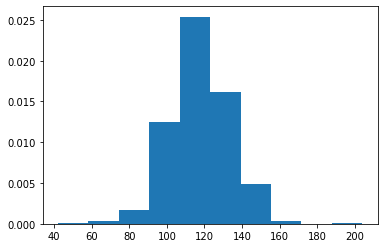

In [1181]:
# Посчитаем среднюю длинну описания, чтобы определить длинну последовательности
train_df['Synopsis_len'] = train_df['Synopsis_encoded'].apply (len)

print ('минимальная длина описания:', train_df.Synopsis_len.min())
print ('средняя длина описания:', round(train_df.Synopsis_len.mean()))
print ('максимальная длина описания:', train_df.Synopsis_len.max())

plt.hist(train_df.Synopsis_len, density = True)

In [1182]:
# Приведем все цепочки в датасете к одной длине с помощью паддинга

MAX_SEQ_LEN = 70

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value= vocabulary['<PAD>'],
    padding= 'post',
    maxlen= MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value= vocabulary['<PAD>'],
    padding= 'post',
    maxlen= MAX_SEQ_LEN)

print('Тернировочные данные:')
print(train_data.shape)
print(train_data[0])
print()
print('Тестовые данные:')
print(test_data.shape)
print(test_data[0])

Тернировочные данные:
(389, 70)
[2166   26   54 5811 5812   31 5813 1262 5814 3225   46  453  162   82
 1614 1260   27  163 3226 5815 1263  281 1264 1615 3227 1261  328 5816
  237 3228   78  209   12  454  238 1265 3229  454 5817  454 1616 5818
  112 5819 5820    7  371  138 2167 1617 3230  408   37 5821 5822  261
 5823 3231 1618    9 1017 1619  409 5824 1620    9    7  210   35 3232]

Тестовые данные:
(320, 70)
[1663    2 1344  385    2  136 7394  328 5679  171    2    2    2    2
    2 1024    2    2 2314 3906  175    2    2 3775  132  238 9731    2
 7951    2 5347   59  316 9269    2 2320  196    2 1322    2    2    2
    2    2    2 6415    2   70    2   16    2    3    2  345    2    2
  872 3562    4    2    6    3    2  938    4   93   10    2   11   40]


In [1183]:
#Разбьем обучающий датасет на обучающий и валидационный

partial_x_train, x_val, partial_y_train, y_val = train_test_split(train_data, train_labels, 
                                                                  test_size = 0.10, random_state = 42)

print(partial_x_train.shape, partial_y_train.shape)
print(x_val.shape, y_val.shape)

(350, 70) (350, 2)
(39, 70) (39, 2)


## 3. Создание и обучение модели

In [1184]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

In [1185]:
# Создадим рекурентную модель для классификации

VOCAB_SIZE = len(vocab_light)
EMB_SIZE = 32
CLASS_NUM = y_val.shape[1]

print(VOCAB_SIZE)
print(EMB_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(EMB_SIZE, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(EMB_SIZE, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(CLASS_NUM, activation= 'sigmoid'),
])


10000
32


In [1194]:
#Обучение модели
BATCH_SIZE = 8
NUM_EPOCHS = 5

#Настраиваем объект для сохранения результатов работы модели
cpt_path = '/content/14_text_classifier.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='acc', verbose=1, save_best_only= True, mode='max')

model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['acc'])

from tensorflow.keras.utils import to_categorical

history= model.fit(partial_x_train, partial_y_train, validation_data= (x_val, y_val), 
                   epochs= NUM_EPOCHS, batch_size= BATCH_SIZE, verbose= 1,
                   callbacks=[checkpoint])


Epoch 1/5
44/44 [==============================] - ETA: 0s - loss: 0.0245 - acc: 0.9943
Epoch 00001: acc improved from -inf to 0.99429, saving model to /content/14_text_classifier.hdf5
44/44 [==============================] - 22s 243ms/step - loss: 0.0245 - acc: 0.9943 - val_loss: 1.7942 - val_acc: 0.6667
Epoch 2/5
44/44 [==============================] - ETA: 0s - loss: 0.0116 - acc: 0.9943
Epoch 00002: acc did not improve from 0.99429
44/44 [==============================] - 10s 223ms/step - loss: 0.0116 - acc: 0.9943 - val_loss: 0.8561 - val_acc: 0.6667
Epoch 3/5
44/44 [==============================] - ETA: 0s - loss: 0.0018 - acc: 1.0000
Epoch 00003: acc improved from 0.99429 to 1.00000, saving model to /content/14_text_classifier.hdf5
44/44 [==============================] - 10s 220ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.7110 - val_acc: 0.7179
Epoch 4/5
44/44 [==============================] - ETA: 0s - loss: 8.3009e-04 - acc: 1.0000
Epoch 00004: acc did not improve fr

In [1193]:
# оценим качество на тестовом датасете

results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

10/10 [==============================] - 0s 33ms/step - loss: 3.1784 - acc: 0.5063
Test loss: 3.1784
Test accuracy: 50.63 %
